In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_excel("C:\\Users\\user\\Desktop\\machine\\data_1017.xlsx",sheet_name="Sheet1")
label_encoder = LabelEncoder()

# 'fixed_type'을 숫자형으로 변환
df['fixed_type_encoded'] = label_encoder.fit_transform(df['fixed_type'])

print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
df = df.drop(['fixed_type','ht_omr_data','FG'], axis=1)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'D1': 4, 'D2': 5, 'E': 6, 'M': 7, 'M1': 8, 'M2': 9, 'Ma': 10, 'Mb': 11, 'Mc': 12, 'R': 13, 'X': 14}


In [2]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
X = df.iloc[:,:-1]

y = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000, stratify=y)

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

# 하이퍼파라미터 탐색 공간 정의
param_distributions = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'min_child_samples': [1 ,2, 4, 8, 16, 32],
    'subsample': [0.5, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.8, 1.0],
    'num_leaves': [16, 24, 32, 48, 64],
    'force_col_wise' : ['True', 'False']
}

# LGBM 모델 초기화
lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=15,
    early_stopping_rounds=20,
    verbose=2
)

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_distributions,
    n_iter=20,  # 시도할 조합의 수
    scoring='neg_log_loss',  # 평가 메트릭
    cv=2,  # 교차 검증 폴드 수
    verbose=2,
    random_state=1000,
    n_jobs=-1  # 모든 CPU 코어 사용
)

# 모델 학습
random_search.fit(
    x_train, y_train,
    eval_set=[(x_test, y_test)],
    eval_metric="multi_logloss"
)

# 최적 하이퍼파라미터 및 모델 출력
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_



Fitting 2 folds for each of 20 candidates, totalling 40 fits
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 24696, number of used features: 30
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Info] Start training from score -1.681020
[LightGBM] [Info] Start training from score -2.396600
[LightGBM] [Info] Start training from score -2.645883
[LightGBM] [Info] Start training from score -2.829576
[LightGBM] [Info] Start training from score -6.376727
[LightGBM] [Info] Start training from score -5.955513
[LightGBM] [Info] Start training from score -5.032992
[LightGBM] [Info] Start training from score -0.817237
[LightGBM] [Info] Start training from score -5.757688
[LightGBM] [Info] Start training from score -8.728102
[Lig

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[14  7  3 ...  1  7  3]
[1.54379776e-05 2.56065309e-04 3.47284170e-05 ... 6.78711642e-01
 1.04530512e-05 1.51562713e-05]
Accuracy: 0.9219


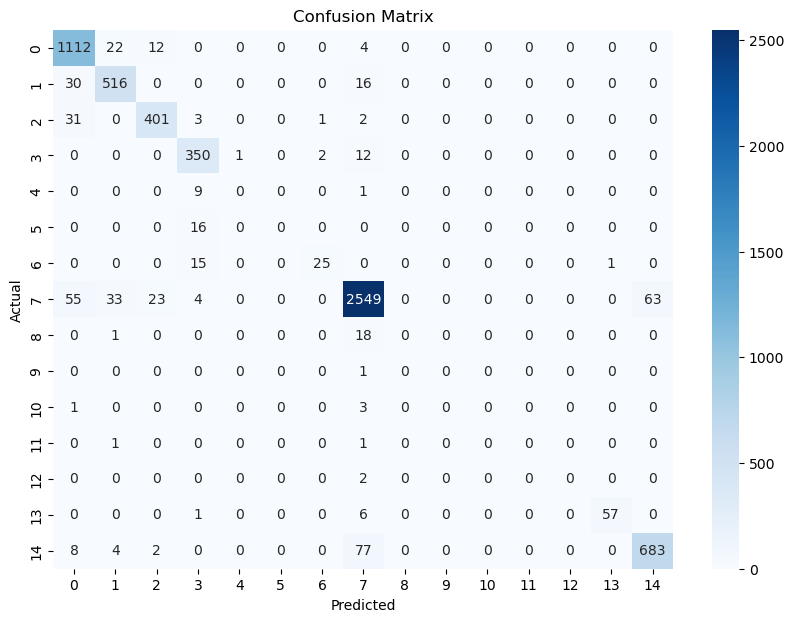

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.93      1150
           1       0.89      0.92      0.91       562
           2       0.92      0.92      0.92       438
           3       0.88      0.96      0.92       365
           4       0.00      0.00      0.00        10
           5       1.00      0.00      0.00        16
           6       0.89      0.61      0.72        41
           7       0.95      0.93      0.94      2727
           8       1.00      0.00      0.00        19
           9       1.00      0.00      0.00         1
          10       1.00      0.00      0.00         4
          11       1.00      0.00      0.00         2
          12       1.00      0.00      0.00         2
          13       0.98      0.89      0.93        64
          14       0.92      0.88      0.90       774

    accuracy                           0.92      6175
   macro avg       0.89      0.47      0.48      6175
we

c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
y_pred = best_model.predict(x_test)
pred_proba = best_model.predict_proba(x_test)[:, 1]

print(y_pred)
print(pred_proba)

# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report (Precision, Recall, F1-Score 포함)
class_report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:\n", class_report)

# Balanced Accuracy (클래스 불균형 문제 해결을 위한 정확도)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score (weighted): {f1:.4f}")

# Precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision (weighted): {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall (weighted): {recall:.4f}")

# ROC-AUC는 다중 클래스 분류에서 각 클래스별로 계산
num_classes = 15  # 전체 클래스 수
y_test_onehot = np.eye(num_classes)[y_test]  # y_test에 대해 one-hot encoding
y_pred_onehot = np.eye(num_classes)[y_pred]  # y_pred에 대해 one-hot encoding

# ROC-AUC 계산 (One-vs-Rest 방식으로 다중 클래스에 대한 ROC-AUC 계산)
roc_auc = roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr', average='weighted')
print(f"ROC-AUC (weighted, OVR): {roc_auc:.4f}")

# Cohen's Kappa 계산
cohen_kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {cohen_kappa:.4f}")

# Matthews Correlation Coefficient (MCC) 계산
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")